In [201]:
import keras
import lime
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import load_img, img_to_array
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import label2rgb
from lime import lime_image
from PIL import ImageFilter, ImageEnhance, Image
from skimage.segmentation import mark_boundaries


np.random.seed(42)
random.seed(42)


class LimeAnalyser:
    def __init__(self):
        self._data = pd.read_csv('all_outputs.csv')
        self._tagged_data_path = '/home/mdrzewiecki/mim/BreastCancerAnalysis/data/'
        self._choose_tagged_sample()
        self._setup_sample_files()
        self._setup_explainer()
        self._positive_label = "Cancer"
        self._negative_label = "Healthy"
        
    @property
    def x(self):
        return self._x
    
    @property
    def y(self):
        return self._y
    
    @property
    def model(self):
        return self._model
    
    @property
    def segmenter(self):
        return self._segmenter
    
    def pred_fn(self, sample):
        return self._model.predict(sample)
    
    def explain_tagged_files(self, num_samples):
        selected_ids = np.random.randint(0, 1000, num_samples)
        _, sample_file_name = os.path.split(self._chosen_image_path)
        image = Image.open(self._chosen_image_path)
        ground_truth = Image.open(self._chosen_image_ground_truth)
        for i in selected_ids:
            print(f"file: {sample_file_name}, sample: {i}")
            
            image_part = image.crop((i, i, i + 50, i + 50))
            ground_truth_part = ground_truth.crop((i, i, i + 50, i + 50))
            ground_truth_part = ground_truth_part.resize((360, 360))
            ground_truth_image = (np.array(ground_truth_part))
            image_part = np.array(image_part)
            
            explanation = self._explainer.explain_instance(
                image_part, self.pred_fn, top_labels=5, num_samples=500, segmentation_fn=analyzer.segmenter, hide_color=0)
            temp_without_background, mask_without_background = explanation.get_image_and_mask(
                explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
            temp_with_background, mask_with_background = explanation.get_image_and_mask(
                explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
            
            img_without_background = mark_boundaries(temp_without_background / 2 + 0.5, mask_without_background.astype("int8"))
            img_with_background = mark_boundaries(temp_with_background / 2 + 0.5, mask_with_background)
                        
                        
            return Image.fromarray(temp_without_background.astype(np.uint8))
            #display(Image.fromarray(img_without_background[0]))
            #display(Image.fromarray(img_with_background[0]))
            display(Image.fromarray(ground_truth_image))
            print(temp_without_background)
            print(mask_without_background)
            
            #plt.imshow(temp_without_background)
            #plt.show()
            #plt.imshow(mask_without_background)
            #plt.show()
            
            #display(result_img)
            
            print("========================================================")
            
    
    def explain_sample_files(self, num_samples=500):
        explanation = explainer.explain_instance(
            analyzer.x[0], 
            classifier_fn=analyzer.model.predict,
            top_labels=2,
            hide_color=0, 
            num_samples=num_samples, 
            segmentation_fn=analyzer.segmenter)
        temp, mask = explanation.get_image_and_mask(analyzer.y[0], positive_only=True, num_features=5, hide_rest=False)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
        ax1.imshow(mask,temp, interpolation = 'nearest')
        ax1.set_title('Positive Regions for {}'.format(analyzer.y[0]))
        temp, mask = explanation.get_image_and_mask(y[0], positive_only=False, num_features=10, hide_rest=False)
        ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
        ax2.set_title('Positive/Negative Regions for {}'.format(analyzer.y[0]))
    
    def _choose_tagged_sample(self):
        self._data_original_images_dir = os.path.join(self._tagged_data_path, 'images')
        self._data_ground_truth_dir = os.path.join(self._tagged_data_path, 'groundTruth_display')
        cases = next(os.walk(self._data_original_images_dir))[2]
        chosen_tagged_image = cases[random.randint(0, len(cases))]
        chosen_tagged_ground_truth = os.path.splitext(chosen_tagged_image)[0]+'.png'
        self._chosen_image_path = os.path.join(self._data_original_images_dir, chosen_tagged_image)
        self._chosen_image_ground_truth = os.path.join(self._data_ground_truth_dir, chosen_tagged_ground_truth)
    
    def _setup_sample_files(self):
        self._false_predictions = self._data.loc[(self._data["pred_y"] > 0.5) != self._data["true_y"]]
        self._false_positives = self._false_predictions.loc[self._false_predictions["pred_y"] > 0.5]
        self._false_negatives = self._false_predictions.loc[self._false_predictions["pred_y"] < 0.5]
        self._false_positive_files = self._false_positives['# file']
        self._false_negative_files = self._false_negatives['# file']
        self._false_negatives_sample = np.random.randint(0, len(self._false_negative_files), 2)
        self._false_positives_sample = np.random.randint(0, len(self._false_positive_files), 2)
        self._false_negative_sample_files = self._false_negative_files.iloc[self._false_negatives_sample]
        self._false_positive_sample_files = self._false_positive_files.iloc[self._false_positives_sample]
        self._sample_files = self._false_positive_sample_files._append(self._false_negative_sample_files)
        self._load_data(sample_files, end=4)
    
    def _load_data(self, files, start=0, end=10, augment_fn=None):
        X = []
        y = []
        for f in files[start:end]:
            print(f'LimeAnalyser._load_data(): Loading file {f}')
            img = load_img(f, target_size=(50, 50))
            if augment_fn is not None:
                sample = augment_fn(img)
            else:    
                sample = tf.convert_to_tensor(img)
            X.append(sample)
            y.append(f[-5])
        self._x = np.stack(X)
        self._y = np.array(y, dtype=float)
    
    def _setup_explainer(self):
        self._model = keras.models.load_model("../models/CanDetect.keras")
        self._explainer = lime_image.LimeImageExplainer(verbose=False)
        self._segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

analyzer = LimeAnalyser()

LimeAnalyser._load_data(): Loading file ../data/12872/0/12872_idx5_x2401_y651_class0.png
LimeAnalyser._load_data(): Loading file ../data/10254/0/10254_idx5_x1551_y1251_class0.png
LimeAnalyser._load_data(): Loading file ../data/10303/1/10303_idx5_x951_y1351_class1.png
LimeAnalyser._load_data(): Loading file ../data/15472/1/15472_idx5_x1451_y1501_class1.png


file: Case_10-04.tif, sample: 106


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 88ms/step


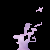

In [202]:
analyzer.explain_tagged_files(3)